<a href="https://colab.research.google.com/github/neutrinoox/projet7-scoring/blob/main/V_Maxime_2_notebook_mod%C3%A9lisation_092025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexte et objectifs
   Ce notebook prépare un pipeline reproductible pour le scoring de crédit. Il structure le chargement des données, le feature engineering, puis les baselines de modélisation.

In [ ]:
import os
from pathlib import Path
import pandas as pd

In [ ]:
# Définit le chemin racine des données
DATA_DIR = Path("data")

# Crée le dossier de cache
DATA_DIR.mkdir(exist_ok=True)

In [ ]:
# Définit le dictionnaire des fichiers à charger
FILES = {
    "application_train": "application_train.csv",
    "application_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "installments_payments": "installments_payments.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv",
    "previous_application": "previous_application.csv",
    "HomeCredit_columns_description": "HomeCredit_columns_description.csv",
    "sample_submission": "sample_submission.csv",
}

# Charge tous les fichiers dans un dictionnaire
raw_data = {}
for name, filename in FILES.items():
    # Construit le chemin final du fichier source
    filepath = DATA_DIR / filename
    # Lit le CSV concerné en conservant les types par défaut
    try:
        raw_data[name] = pd.read_csv(filepath, encoding="utf-8", sep=',', low_memory=False, on_bad_lines='warn')
    except UnicodeDecodeError:
        raw_data[name] = pd.read_csv(filepath, encoding="latin1", sep=',', low_memory=False, on_bad_lines='warn')

/tmp/ipython-input-2232238573.py:22: ParserWarning: Skipping line 55462: expected 37 fields, saw 54

  raw_data[name] = pd.read_csv(filepath, encoding="utf-8", sep=',', low_memory=False, on_bad_lines='warn')


In [ ]:
def eda_basique(df, nom_df="DataFrame"):
    print(f"\n--- Analyse de {nom_df} ---")

    # Dimensions du DataFrame
    print(f"Shape (lignes, colonnes) : {df.shape}")

    # Liste des colonnes
    print("\n Colonnes :")
    print(df.columns.tolist())

    # Valeurs manquantes
    print("\n Valeurs manquantes (par colonne) :")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    display(missing.to_frame(name="Nb de NaN"))

    # Statistiques descriptives
    print("\n Statistiques descriptives (variables numériques) :")
    display(df.describe().transpose())

    # Exemple de données
    print("\n Extrait (premières lignes) :")
    display(df.head())

In [ ]:
eda_basique(raw_data['sample_submission'], "sample_submission")


--- Analyse de sample_submission ---
Shape (lignes, colonnes) : (48744, 2)

 Colonnes :
['SK_ID_CURR', 'TARGET']

 Valeurs manquantes (par colonne) :


,Nb de NaN



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,48744.0,277796.67635,103169.547296,100001.0,188557.75,277549.0,367555.5,456250.0
TARGET,48744.0,0.50000,0.000000,0.5,0.50,0.5,0.5,0.5



 Extrait (premières lignes) :


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


## Analyse du fichier `sample_submission.csv`

Ce fichier contient **2 colonnes** :
- `SK_ID_CURR` : l’identifiant unique d’un client.
- `TARGET` : une valeur de prédiction **fictive**, ici toujours à `0.5`.

Ce fichier est un **exemple de format de soumission** pour des compétitions de type Kaggle. Il montre à quoi devrait ressembler un fichier contenant les prédictions finales du modèle pour le jeu de test (`application_test.csv`).

---

###  Pourquoi ce fichier ne sera **pas utilisé** dans le projet

Dans notre contexte, on ne participe **pas à une compétition Kaggle**, mais on développe un **dashboard interactif** pour expliquer les décisions d’octroi de crédit.  
Nous allons donc nous appuyer sur :
- les **vraies données clients** (`application_train.csv`, `application_test.csv`),
- et notre **modèle/API existant** pour produire les scores.

Le fichier `sample_submission.csv` ne nous est **d’aucune utilité directe** ici.

In [ ]:
eda_basique(raw_data['POS_CASH_balance'], "POS_CASH_balance")


--- Analyse de POS_CASH_balance ---
Shape (lignes, colonnes) : (453717, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


,Nb de NaN
CNT_INSTALMENT_FUTURE,704
CNT_INSTALMENT,702
NAME_CONTRACT_STATUS,1
SK_DPD,1
SK_DPD_DEF,1



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,453717.0,1.903936e+06,535596.987128,1000001.0,1434139.0,1897530.0,2369271.0,2843497.0
SK_ID_CURR,453717.0,2.787908e+05,102814.182221,100003.0,189888.0,279269.0,368163.0,456255.0
MONTHS_BALANCE,453717.0,-2.673459e+01,23.723450,-96.0,-40.0,-17.0,-10.0,-1.0
CNT_INSTALMENT,453015.0,2.045353e+01,14.112832,1.0,10.0,14.0,24.0,72.0
CNT_INSTALMENT_FUTURE,453013.0,1.303106e+01,12.932101,0.0,4.0,9.0,18.0,70.0
SK_DPD,453716.0,3.594517e-01,15.728253,0.0,0.0,0.0,0.0,2672.0
SK_DPD_DEF,453716.0,6.820787e-02,1.448846,0.0,0.0,0.0,0.0,268.0



 Extrait (premières lignes) :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0.0,0.0
1,1715348,367990,-33,36.0,35.0,Active,0.0,0.0
2,1784872,397406,-32,12.0,9.0,Active,0.0,0.0
3,1903291,269225,-35,48.0,42.0,Active,0.0,0.0
4,2341044,334279,-35,36.0,35.0,Active,0.0,0.0


## Analyse du fichier `POS_CASH_balance.csv`

Ce fichier contient des **informations mensuelles** sur les crédits **POS (point of sale)** ou **CASH** contractés par les clients.

Chaque ligne correspond à **un mois de suivi d’un crédit** (d’où la colonne `MONTHS_BALANCE`).

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de crédit (liée à un client) | Non, identifiant technique |
| `SK_ID_CURR` | ID du client (clé principale) | Oui, pour relier au client |
| `MONTHS_BALANCE` | Mois relatif : 0 = mois actuel, -1 = mois précédent, etc. | Peut être utile si analyse temporelle |
| `CNT_INSTALMENT` | Nombre total d’échéances prévues du crédit | Potentiellement utile (longueur du crédit) |
| `CNT_INSTALMENT_FUTURE` | Nombre d’échéances restantes à ce moment-là | Oui (endettement restant) |
| `NAME_CONTRACT_STATUS` | Statut du crédit ce mois-là (Active, Completed, etc.) | Oui (situation actuelle ou passée) |
| `SK_DPD` | Jours de retard de paiement (jours de retard > 0) | Oui (comportement de remboursement) |
| `SK_DPD_DEF` | Jours de retard "défaut" (dépassant un seuil critique)  Oui (indicateur fort de défaut) |

---

- Les colonnes `SK_DPD` et `SK_DPD_DEF` sont intéressantes pour mesurer **la fiabilité de remboursement passée** d’un client.
- Les colonnes `CNT_INSTALMENT` et `CNT_INSTALMENT_FUTURE` donnent une idée de **l’état d’un crédit en cours**.
- Le statut du contrat (`NAME_CONTRACT_STATUS`) permet de savoir si le crédit est **encore actif ou terminé**.

- Ce fichier contient **beaucoup de lignes (plus de 100 000)** car il suit les crédits mois par mois.
- Il faudrait le **résumer** pour pouvoir l’utiliser dans le dashboard (par exemple : nombre de crédits actifs, total de jours de retard moyen, etc.).
- Cela demande un **prétraitement avancé** (agrégations par client), ce qui dépasse le besoin immédiat du dashboard centré sur **l’interprétation d’un score individuel**.

**Conclusion** : Ce fichier est **intéressant pour enrichir un modèle**, mais il ne sera **pas utilisé directement** dans le dashboard sans prétraitement.

In [13]:
eda_basique(raw_data['installments_payments'], "installments_payments")


--- Analyse de installments_payments ---
Shape (lignes, colonnes) : (2959199, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

 Valeurs manquantes (par colonne) :


,Nb de NaN
NUM_INSTALMENT_VERSION,1
NUM_INSTALMENT_NUMBER,1
DAYS_INSTALMENT,1
DAYS_ENTRY_PAYMENT,1
AMT_INSTALMENT,1
AMT_PAYMENT,1



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,2959199.0,1.901124e+06,536063.674142,1000001.0,1431164.000,1895664.00,2366409.00,2843491.000
SK_ID_CURR,2959199.0,1.501385e+05,28908.875665,1.0,125154.000,150096.00,175295.00,199999.000
NUM_INSTALMENT_VERSION,2959198.0,8.551222e-01,0.998934,0.0,0.000,1.00,1.00,43.000
NUM_INSTALMENT_NUMBER,2959198.0,1.893174e+01,26.834012,1.0,4.000,8.00,19.00,244.000
DAYS_INSTALMENT,2959198.0,-1.044788e+03,801.904941,-2922.0,-1658.000,-822.00,-362.00,-2.000
DAYS_ENTRY_PAYMENT,2959198.0,-1.053591e+03,801.503992,-3115.0,-1667.000,-831.00,-371.00,-2.000
AMT_INSTALMENT,2959198.0,1.707452e+04,51152.167607,0.0,4225.995,8882.28,16660.98,3473582.895
AMT_PAYMENT,2959198.0,1.724955e+04,55281.879199,0.0,3399.660,8127.45,16056.81,3473582.895



 Extrait (premières lignes) :


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6.0,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34.0,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1.0,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3.0,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2.0,-1383.0,-1366.0,2165.040,2160.585


## Analyse du fichier `installments_payments.csv`

Ce fichier contient des informations détaillées sur les **paiements effectués par les clients** sur leurs crédits précédents, échéance par échéance.

Chaque ligne correspond à un **paiement prévu vs réel** pour un crédit donné.

---

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de crédit |  Non |
| `SK_ID_CURR` | ID du client (clé principale) | Oui |
| `NUM_INSTALMENT_VERSION` | Version de l’échéancier | Non |
| `NUM_INSTALMENT_NUMBER` | Numéro de l’échéance (1er, 2e, etc.) | Pas directement |
| `DAYS_INSTALMENT` | Jour prévu pour l’échéance (relatif au jour actuel) | Oui, Pour évaluer la ponctualité |
| `DAYS_ENTRY_PAYMENT` | Jour réel du paiement effectué | Oui, Pour calculer le retard |
| `AMT_INSTALMENT` | Montant dû pour cette échéance | Oui, indice du poids des mensualités |
| `AMT_PAYMENT` | Montant réellement payé | Oui, Pour savoir si le paiement a été partiel ou total |

---

Ce fichier est **extrêmement utile pour comprendre les habitudes de remboursement** des clients dans le passé :
- Ponctualité : en comparant `DAYS_INSTALMENT` et `DAYS_ENTRY_PAYMENT` → si le client est souvent en retard.
- Paiements partiels : en comparant `AMT_INSTALMENT` et `AMT_PAYMENT`.

Je peux en déduire des **indicateurs puissants** pour enrichir le modèle ou le dashboard :
- Moyenne de retard de paiement.
- % de paiements effectués en totalité.
- Nombre d’échéances payées en retard.

Comme `POS_CASH_balance`, ce fichier contient **plusieurs lignes par client**. Il faut donc :
- Faire des **agrégations par client** (via `SK_ID_CURR`) pour le résumer.
- Ensuite, intégrer ces indicateurs dans le modèle ou le dashboard.

In [ ]:
eda_basique(raw_data['credit_card_balance'], "credit_card_balance")


--- Analyse de credit_card_balance ---
Shape (lignes, colonnes) : (1674586, 23)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


,Nb de NaN
AMT_PAYMENT_CURRENT,344865
AMT_DRAWINGS_ATM_CURRENT,339834
CNT_DRAWINGS_ATM_CURRENT,339834
AMT_DRAWINGS_POS_CURRENT,339834
AMT_DRAWINGS_OTHER_CURRENT,339834
CNT_DRAWINGS_OTHER_CURRENT,339834
CNT_DRAWINGS_POS_CURRENT,339834
CNT_INSTALMENT_MATURE_CUM,123426
AMT_INST_MIN_REGULARITY,123426
AMT_DRAWINGS_CURRENT,1



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,1674586.0,1.904431e+06,536604.993433,1000018.000,1431899.000,1897474.000,2369424.000,2843496.000
SK_ID_CURR,1674585.0,2.782943e+05,102689.671396,100006.000,189534.000,278394.000,367558.000,456250.000
MONTHS_BALANCE,1674585.0,-3.374359e+01,27.462162,-96.000,-55.000,-26.000,-10.000,-1.000
AMT_BALANCE,1674585.0,5.704038e+04,103999.333203,-261471.015,0.000,0.000,87800.085,1505902.185
AMT_CREDIT_LIMIT_ACTUAL,1674585.0,1.522937e+05,164195.114096,0.000,45000.000,112500.000,180000.000,1350000.000
AMT_DRAWINGS_ATM_CURRENT,1334752.0,5.745902e+03,27427.079789,0.000,0.000,0.000,0.000,1676250.000
AMT_DRAWINGS_CURRENT,1674585.0,7.051616e+03,32585.194847,-1687.500,0.000,0.000,0.000,2287098.315
AMT_DRAWINGS_OTHER_CURRENT,1334752.0,2.732948e+02,7706.041067,0.000,0.000,0.000,0.000,899910.000
AMT_DRAWINGS_POS_CURRENT,1334752.0,2.812136e+03,20074.460373,0.000,0.000,0.000,0.000,1933462.125
AMT_INST_MIN_REGULARITY,1551160.0,3.475082e+03,5502.827945,0.000,0.000,0.000,6300.000,126728.145



 Extrait (premières lignes) :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907.0,-6.0,56.970,135000.0,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1.0,0.0,1.0,35.0,Active,0.0,0.0
1,2582071,363914.0,-1.0,63975.555,45000.0,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1.0,0.0,0.0,69.0,Active,0.0,0.0
2,1740877,371185.0,-7.0,31815.225,450000.0,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0.0,0.0,0.0,30.0,Active,0.0,0.0
3,1389973,337855.0,-4.0,236572.110,225000.0,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1.0,0.0,0.0,10.0,Active,0.0,0.0
4,1891521,126868.0,-1.0,453919.455,450000.0,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1.0,0.0,1.0,101.0,Active,0.0,0.0


## Analyse du fichier `credit_card_balance.csv`

Ce fichier contient des **informations mensuelles sur les cartes de crédit** détenues par les clients.

Chaque ligne représente **l’état d’un compte carte de crédit** pour **un mois donné**, ce qui explique pourquoi il y a plusieurs lignes par client.

---

### Colonnes principales et leur signification

| Colonne | Description | Utile pour le dashboard ? |
|---------|-------------|---------------------------|
| `SK_ID_PREV` | ID du crédit (lié au compte carte) | Non |
| `SK_ID_CURR` | ID du client | Oui |
| `MONTHS_BALANCE` | Mois (relatif au mois actuel, 0 = actuel) | Non directement |
| `AMT_BALANCE` | Montant total dû sur la carte | Oui |
| `AMT_CREDIT_LIMIT_ACTUAL` | Limite de crédit actuelle | Oui |
| `AMT_DRAWINGS_ATM_CURRENT` | Montant retiré au distributeur ce mois |Potentiellement |
| `AMT_DRAWINGS_CURRENT` | Montant total retiré | Peut indiquer l’utilisation active |
| `AMT_DRAWINGS_OTHER_CURRENT` | Montants retirés ailleurs (online, etc.) | Trop spécifique |
| `AMT_DRAWINGS_POS_CURRENT` | Montants dépensés en magasin | Peut indiquer habitudes de conso |
| `AMT_INST_MIN_REGULARITY` | Montant minimum à payer ce mois | Oui |
| `AMT_PAYMENT_CURRENT` | Montant effectivement payé | Oui |
| `AMT_PAYMENT_TOTAL_CURRENT` | Paiement total (y compris intérêts) | Oui |
| `AMT_RECEIVABLE_PRINCIPAL` | Principal dû (hors intérêts) | Oui |
| `AMT_RECIVABLE` | Montant total à récupérer (possible doublon) |Non, Doublon probable |
| `AMT_TOTAL_RECEIVABLE` | Total dû client (intérêts inclus) | Oui |
| `CNT_DRAWINGS_ATM_CURRENT` | Nombre de retraits au DAB ce mois | Trop granulaire |
| `CNT_DRAWINGS_CURRENT` | Nombre total d'opérations ce mois | Peut être utile |
| `CNT_DRAWINGS_OTHER_CURRENT` | Autres retraits | Non |
| `CNT_DRAWINGS_POS_CURRENT` | Nombre d’achats en magasin | Non |
| `CNT_INSTALMENT_MATURE_CUM` | Nb d'échéances arrivées à terme | Pas pertinent |
| `NAME_CONTRACT_STATUS` | Statut du compte (Active, Closed) | Oui |
| `SK_DPD` | Jours de retard de paiement ce mois | Très utile |
| `SK_DPD_DEF` | Retards "défaut" ce mois | Très utile |

---

Ce fichier permet de suivre **le comportement de gestion des cartes de crédit**, ce qui est **fortement lié au risque de défaut** :
- Est-ce que le client paie ce qu’il doit ? (`AMT_PAYMENT_CURRENT`)
- A-t-il accumulé du solde impayé ? (`AMT_BALANCE`)
- Fait-il souvent des **retards de paiement** ? (`SK_DPD`)
- Utilise-t-il **la totalité de sa limite de crédit** ? (`AMT_BALANCE` vs `AMT_CREDIT_LIMIT_ACTUAL`)

Comme les autres fichiers mensuels (`POS_CASH_balance`, `installments_payments`), ce fichier contient **plusieurs lignes par client**.

Il devra être **agrégé** par client (via `SK_ID_CURR`) avant utilisation dans le dashboard.  
Je peux en tirer par exemple :
- Solde moyen de la carte (`mean(AMT_BALANCE)`),
- % de mois avec retard (`mean(SK_DPD > 0)`),
- Taux d'utilisation de la limite (`AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL`).

In [ ]:
eda_basique(raw_data['HomeCredit_columns_description'], "HomeCredit_columns_description")


--- Analyse de HomeCredit_columns_description ---
Shape (lignes, colonnes) : (219, 5)

 Colonnes :
['Unnamed: 0', 'Table', 'Row', 'Description', 'Special']

 Valeurs manquantes (par colonne) :


,Nb de NaN
Special,133



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,219.0,111.981735,63.395726,1.0,57.5,112.0,166.5,221.0



 Extrait (premières lignes) :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de données**.  
Il décrit chaque colonne présente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier où se trouve la colonne décrite |
| `Row` | Nom de la colonne concernée |
| `Description` | Brève explication de ce que contient cette colonne |
| `Special` | Informations supplémentaires éventuelles (souvent vide) |


Ce fichier est **très utile en phase d’exploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables catégorielles ou booléennes.
- Repérer les colonnes redondantes ou inutiles.

Il ne sera **pas utilisé directement** dans le dashboard ou dans le modèle.

Ce fichier **ne contient pas de données clients**, uniquement des **métadonnées**.  
Il est donc à consulter manuellement pour mieux travailler sur les autres fichiers.

In [ ]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (13494293, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


,Nb de NaN
STATUS,1



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,13494293.0,5.997129e+06,495725.176705,5001710.0,5724691.0,6028802.0,6399998.0,6837604.0
MONTHS_BALANCE,13494293.0,-3.035069e+01,23.707446,-96.0,-45.0,-25.0,-11.0,0.0



 Extrait (premières lignes) :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de données**.  
Il décrit chaque colonne présente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier où se trouve la colonne décrite |
| `Row` | Nom de la colonne concernée |
| `Description` | Brève explication de ce que contient cette colonne |
| `Special` | Informations supplémentaires éventuelles (souvent vide) |


Ce fichier est **très utile en phase d’exploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables catégorielles ou booléennes.
- Repérer les colonnes redondantes ou inutiles.

Il ne sera **pas utilisé directement** dans le dashboard ou dans le modèle.

Ce fichier **ne contient pas de données clients**, uniquement des **métadonnées**.  
Il est donc à consulter manuellement pour mieux travailler sur les autres fichiers.

In [ ]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (27299925, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


,Nb de NaN



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.0,6.036297e+06,492348.856904,5001709.0,5730933.0,6070821.0,6431951.0,6842888.0
MONTHS_BALANCE,27299925.0,-3.074169e+01,23.864509,-96.0,-46.0,-25.0,-11.0,0.0



 Extrait (premières lignes) :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## Analyse du fichier `bureau_balance.csv`

Ce fichier contient des informations **mensuelles** sur l’évolution des crédits répertoriés dans le fichier `bureau.csv`.

Chaque ligne correspond à **un mois de suivi d’un crédit externe** (non contracté chez Prêt à Dépenser).


| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_BUREAU` | Identifiant du crédit dans `bureau.csv` | Oui, Pour faire une jointure |
| `MONTHS_BALANCE` | Mois de l’observation (0 = actuel, -1 = mois précédent...) | Non, Trop détaillé pour le dashboard |
| `STATUS` | Statut du crédit ce mois-là (ex : "C" = en cours, "0", "1", etc. = niveaux de retard) | Oui (comportement de paiement) |

---

Le fichier permet de **suivre l’historique d’un crédit externe** mois après mois :
- Le statut `"C"` indique que le crédit était actif mais à jour.
- Des valeurs numériques (`"0"`, `"1"`, ..., `"5"`) indiquent des mois de **retard de paiement**.
- `"X"` ou `NaN` peuvent signaler **informations manquantes ou clôtures**.

En analysant `STATUS`, on peut construire des indicateurs par client :
- Nombre de mois en retard,
- Retard maximum atteint,
- Ratio de mois à l’heure / total,
- Nombre de crédits "à problème".

Comme pour `installments_payments` et `POS_CASH_balance`, ce fichier contient **plusieurs lignes par crédit**, donc **beaucoup trop de granularité** pour l'affichage direct dans un dashboard.
Il doit être **agrégé par `SK_ID_BUREAU`**, puis lié à `bureau.csv`, puis résumé par `SK_ID_CURR`.

In [17]:
eda_basique(raw_data['bureau'], "bureau")


--- Analyse de bureau ---
Shape (lignes, colonnes) : (1716428, 17)

 Colonnes :
['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

 Valeurs manquantes (par colonne) :


,Nb de NaN
AMT_ANNUITY,1226791
AMT_CREDIT_MAX_OVERDUE,1124488
DAYS_ENDDATE_FACT,633653
AMT_CREDIT_SUM_LIMIT,591780
AMT_CREDIT_SUM_DEBT,257669
DAYS_CREDIT_ENDDATE,105553
AMT_CREDIT_SUM,13



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08
CNT_CREDIT_PROLONG,1716428.0,6.410406e-03,9.622391e-02,0.000,0.00,0.0,0.00,9.000000e+00
AMT_CREDIT_SUM,1716415.0,3.549946e+05,1.149811e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08



 Extrait (premières lignes) :


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## Analyse du fichier `bureau.csv`

Ce fichier contient un **historique de tous les crédits contractés par le client** dans d’autres établissements financiers que "Prêt à Dépenser".

Chaque ligne correspond à **un crédit externe** détenu par un client.

---

| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_CURR` | ID du client | Oui (clé principale de jointure) |
| `SK_ID_BUREAU` | ID du crédit externe (clé pour `bureau_balance`) | Oui |
| `CREDIT_ACTIVE` | Statut du crédit (ex: Active, Closed, Sold, Bad debt) |  Oui (indique si le crédit est en cours) |
| `CREDIT_CURRENCY` | Devise du crédit | Non pertinent ici |
| `DAYS_CREDIT` | Nombre de jours depuis l’octroi du crédit | Oui (ancienneté du crédit) |
| `CREDIT_DAY_OVERDUE` | Nb de jours de retard actuel (si >0) | Oui (indique un défaut) |
| `DAYS_CREDIT_ENDDATE` | Durée prévue du crédit (en jours) | Oui |
| `DAYS_ENDDATE_FACT` | Date réelle de fin (si déjà terminé) | Oui (permet de savoir s’il a été remboursé) |
| `AMT_CREDIT_MAX_OVERDUE` | Max. de dépassement enregistré | Oui |
| `CNT_CREDIT_PROLONG` | Nb de prolongations demandées | Oui (signe de difficulté potentielle) |
| `AMT_CREDIT_SUM` | Montant total du crédit |  Oui |
| `AMT_CREDIT_SUM_DEBT` | Montant encore dû |  Oui |
| `AMT_CREDIT_SUM_LIMIT` | Plafond de crédit (pour revolving) | Potentiellement |
| `AMT_CREDIT_SUM_OVERDUE` | Montant en retard de paiement | Oui |
| `CREDIT_TYPE` | Type de crédit (Loan, Car, Credit Card, etc.) | Oui (comportement par type) |
| `DAYS_CREDIT_UPDATE` | Dernière mise à jour | Non utile ici |
| `AMT_ANNUITY` | Montant de l’annuité (mensualités) | Oui (effort de remboursement) |

Ce fichier permet de construire des **indicateurs globaux sur l'endettement passé du client** :
- Nombre total de crédits encore actifs.
- Montant total dû sur les crédits externes.
- Retards de paiement récents ou passés.
- Types de crédits sollicités (habitudes financières).

Contrairement à `bureau_balance`, ce fichier est **déjà résumé par crédit** (pas par mois), donc :
- Il est **plus facile à agréger directement par client**.
- Il peut être utilisé **dans le modèle** et potentiellement dans le **dashboard**, après **quelques résumés simples** (ex: somme des dettes en cours, nombre de crédits actifs, etc.).

In [18]:
eda_basique(raw_data['application_train'], "application_train")


--- Analyse de application_train ---
Shape (lignes, colonnes) : (307511, 122)

 Colonnes :
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 

,Nb de NaN
COMMONAREA_MEDI,214865
COMMONAREA_MODE,214865
COMMONAREA_AVG,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_MEDI,213514
...,...
EXT_SOURCE_2,660
AMT_GOODS_PRICE,278
AMT_ANNUITY,12
CNT_FAM_MEMBERS,2



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0



 Extrait (premières lignes) :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Analyse du fichier `application_train.csv`

Fichier principal du projet : chaque ligne correspond à **un client**, identifié par `SK_ID_CURR`.  
Ce fichier contient la **target** (`TARGET` = 1 si défaut de paiement, 0 sinon) et toutes les **variables socio-démographiques**, financières et professionnelles des clients.

---

### Structure des colonnes (groupe par thème)

#### 1. **Identification & cible**
| Colonne | Description | Utile ? |
|---------|-------------|---------|
| `SK_ID_CURR` | Identifiant unique du client | Oui,  Clé principale |
| `TARGET` | 1 = défaut, 0 = remboursement | Oui, Variable cible |

---

#### 2. **Informations personnelles & sociales**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `CODE_GENDER`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_INCOME_TYPE`, `NAME_HOUSING_TYPE`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS` | Infos de base sur la situation personnelle | Oui, pour profil client |

---

#### 3. **Situation professionnelle et revenus**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_GOODS_PRICE`, `AMT_ANNUITY`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` | Infos sur les revenus, crédit demandé et emploi |Oui, utile pour l’analyse du risque |

---

####  4. **Dates (jours négatifs)**
| Exemple | Commentaires | Utile ? |
|--------|--------------|---------|
| `DAYS_BIRTH`, `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH`, `DAYS_LAST_PHONE_CHANGE` | Dates exprimées en jours avant aujourd’hui (ex: -12000) | Oui, à transformer pour lisibilité |
| `OWN_CAR_AGE` | Âge de la voiture | Non, Pas prioritaire |

---

#### 5. **Sources de scoring externe**
| Colonnes | Commentaires | Utile ? |
|----------|-------------|---------|
| `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` | Scores externes prédictifs du risque | Oui, Très corrélées à la cible, utiles pour modèle |

---

####  6. **Indicateurs régionaux & géographiques**
| Exemple | Commentaires | Utile ? |
|--------|-------------|---------|
| `REGION_POPULATION_RELATIVE`, `REGION_RATING_CLIENT`, `LIVE_REGION_NOT_WORK_REGION`... | Infos sur la région du client | Trop techniques ou redondants pour le dashboard |

---

#### 7. **Logements & biens immobiliers**
| Exemple | Commentaires | Utile ? |
|---------|-------------|---------|
| `APARTMENTS_AVG`, `BASEMENTAREA_AVG`, `YEARS_BUILD_AVG`, ... (et leurs variantes _MODE, _MEDI) | 50+ colonnes très techniques sur le logement | Trop granulaire pour le dashboard |

---

#### 8. **Documents fournis**
| Exemple | `FLAG_DOCUMENT_2` à `FLAG_DOCUMENT_21` | Soumis pour demande de crédit | Peu informatif |

---

####  9. **Demandes au bureau de crédit**
| Exemple | `AMT_REQ_CREDIT_BUREAU_*` | Fréquence des requêtes au bureau | Trop technique pour le dashboard |

In [19]:
eda_basique(raw_data['application_test'], "application_test")


--- Analyse de application_test ---
Shape (lignes, colonnes) : (48744, 121)

 Colonnes :
['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTARE

,Nb de NaN
COMMONAREA_AVG,33495
COMMONAREA_MODE,33495
COMMONAREA_MEDI,33495
NONLIVINGAPARTMENTS_AVG,33347
NONLIVINGAPARTMENTS_MODE,33347
...,...
OBS_30_CNT_SOCIAL_CIRCLE,29
OBS_60_CNT_SOCIAL_CIRCLE,29
DEF_60_CNT_SOCIAL_CIRCLE,29
AMT_ANNUITY,24



 Statistiques descriptives (variables numériques) :


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,48744.0,277796.676350,103169.547296,100001.0,188557.75,277549.0,367555.5,456250.0
CNT_CHILDREN,48744.0,0.397054,0.709047,0.0,0.00,0.0,1.0,20.0
AMT_INCOME_TOTAL,48744.0,178431.805855,101522.591536,26941.5,112500.00,157500.0,225000.0,4410000.0
AMT_CREDIT,48744.0,516740.435561,365397.004174,45000.0,260640.00,450000.0,675000.0,2245500.0
AMT_ANNUITY,48720.0,29426.240209,16016.368315,2295.0,17973.00,26199.0,37390.5,180576.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,42695.0,0.001803,0.046132,0.0,0.00,0.0,0.0,2.0
AMT_REQ_CREDIT_BUREAU_WEEK,42695.0,0.002787,0.054037,0.0,0.00,0.0,0.0,2.0
AMT_REQ_CREDIT_BUREAU_MON,42695.0,0.009299,0.110924,0.0,0.00,0.0,0.0,6.0
AMT_REQ_CREDIT_BUREAU_QRT,42695.0,0.546902,0.693305,0.0,0.00,0.0,1.0,7.0



 Extrait (premières lignes) :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Analyse du fichier `application_test.csv`

Ce fichier contient les **informations clients pour lesquels on doit prédire un score**, mais **sans la colonne `TARGET`** (c’est le jeu de test).

Il contient les **mêmes types de variables** que `application_train.csv` :
- Données personnelles
- Données financières
- Données professionnelles
- Caractéristiques du logement
- Scores externes, etc.

---

### Structure des colonnes (même logique que `application_train.csv`)

####  1. **Identification**
- `SK_ID_CURR` : identifiant du client → **clé primaire** pour relier les infos.

---

#### 2. **Colonnes à conserver pour le modèle ou le dashboard**
| Thème | Colonnes utiles |
|-------|-----------------|
| Socio-démographie | `CODE_GENDER`, `CNT_CHILDREN`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_HOUSING_TYPE`, `CNT_FAM_MEMBERS`, `FLAG_OWN_REALTY` |
| Revenus et crédits | `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` |
| Scores de risque | `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` |
| Dates utiles | `DAYS_BIRTH`, `DAYS_LAST_PHONE_CHANGE` |

---

#### 3. **Colonnes à écarter ou moins pertinentes pour le dashboard**
| Groupe | Exemple de colonnes |
|--------|----------------------|
| Données logement détaillées | `APARTMENTS_AVG`, `BASEMENTAREA_MODE`, `FLOORSMAX_MEDI`, etc. (60+ colonnes très spécifiques) |
| Documents fournis | `FLAG_DOCUMENT_2` à `FLAG_DOCUMENT_21` |
| Requêtes au bureau de crédit | `AMT_REQ_CREDIT_BUREAU_*` |
| Variables régionales techniques | `REG_REGION_NOT_LIVE_REGION`, `LIVE_REGION_NOT_WORK_REGION`, etc. |

---

- `application_test.csv` est le **jeu de données d’inférence**, qui sera utilisé **par mon API** pour générer un score à afficher dans le dashboard.
- Il contient les **mêmes colonnes utiles** que `application_train.csv`, sauf `TARGET`.
- Il devra être **prétraité de la même manière**, et utilisé dans le dashboard pour :
  - afficher les infos client,
  - récupérer les features,
  - envoyer à mon API pour obtenir une **prédiction à afficher**.

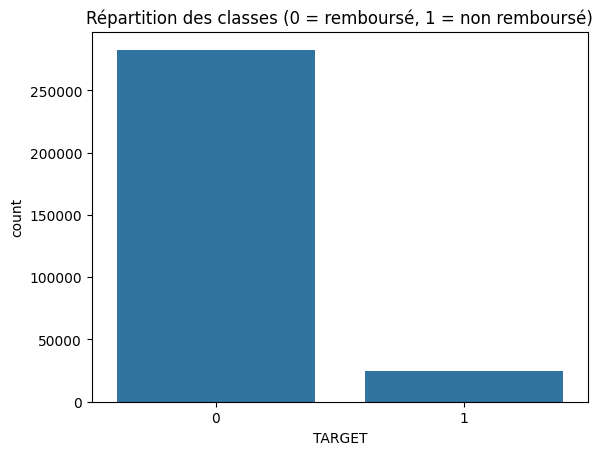

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=raw_data['application_train'], x='TARGET')
plt.title("Répartition des classes (0 = remboursé, 1 = non remboursé)")
plt.show()

print(raw_data['application_train']['TARGET'].value_counts(normalize=True))

Comme il est indiqué qu'on le peut dans l'intitulé du projet, je vais fortement m'inspirer du Kaggle mis à disposition pour l'analyse exploratoire et le feature engineering. Je vais ajouter mes propres commentaires et autres visualisations supplémentaires que je trouve pertinentes pour répondre à la problématique métier et comprendre les données. De plus, avant de me servir de ces notebooks Kaggle, j'ai moi même analysé chaque df et chaque colonne pour comprendre exactement de quoi il retourne. Je vais ensuite créer mes propres modèles de machine learning, optimiser les hyperparamètres à ma façon et choisir les métriques d'évaluation que je trouve les plus pertinentes.

In [21]:
raw_data['application_train']['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


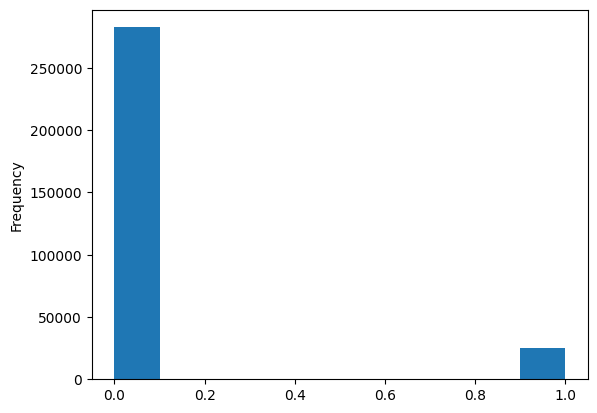

In [22]:
raw_data['application_train']['TARGET'].astype(int).plot.hist();

In [23]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
missing_values_table(raw_data['application_train'])

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


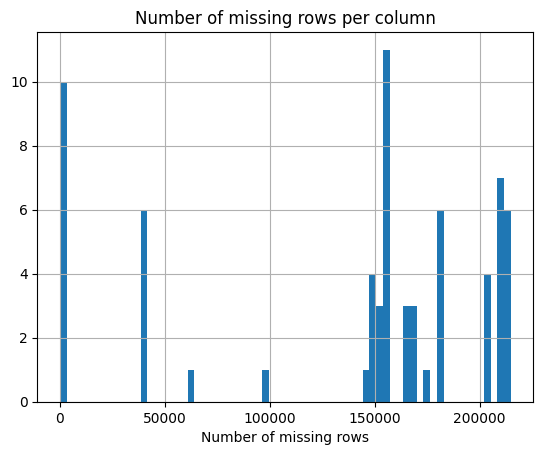

In [25]:
#We now have to deal with columns that contains null values
missing = raw_data['application_train'].isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

#Lets visualize the number of null values in all the columns
missing.hist(bins=len(missing))
plt.title('Number of missing rows per column')
plt.xlabel('Number of missing rows')
plt.show()

In [26]:
# Number of unique classes in each object column
raw_data['application_train'].select_dtypes('object').apply(pd.Series.nunique, axis = 0)

,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


In [27]:
# Number of each type of column
raw_data['application_train'].dtypes.value_counts()

,count
float64,65
int64,41
object,16


In [28]:
# Sauvegarde de la variable cible avant alignement
etiquettes_cible = raw_data['application_train']['TARGET']

# Alignement des colonnes entre les deux datasets (on garde uniquement les colonnes communes)
application_train, application_test = raw_data['application_train'].align(raw_data['application_test'], join='inner', axis=1)

# Réintégration de la variable cible dans le jeu d'entraînement
application_train['TARGET'] = etiquettes_cible

# Affichage des dimensions finales
print("Shape du jeu d'entraînement :", application_train.shape)
print("Shape du jeu de test :", application_test.shape)

Shape du jeu d'entraînement : (307511, 122)
Shape du jeu de test : (48744, 121)


In [29]:
(application_train['DAYS_BIRTH'] / -365).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


In [30]:
application_train['DAYS_EMPLOYED'].describe()

,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


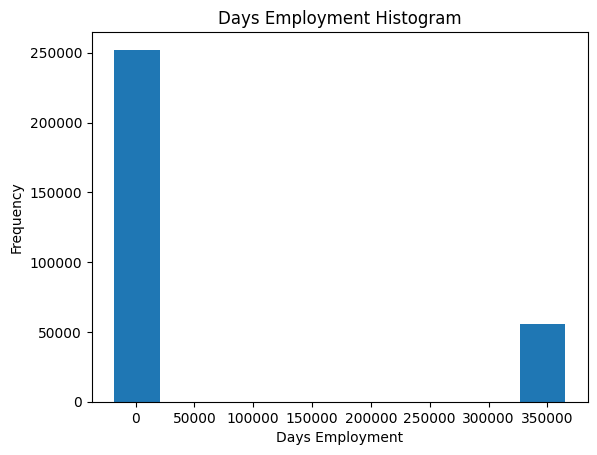

In [31]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [32]:
# Séparation entre les valeurs normales et les valeurs anormales de la variable DAYS_EMPLOYED
valeurs_anormales = application_train[application_train['DAYS_EMPLOYED'] == 365243]
valeurs_normales = application_train[application_train['DAYS_EMPLOYED'] != 365243]

# Affichage du taux de défaut pour les deux groupes
print("Les clients sans anomalie de durée d'emploi ont un taux de défaut de : %0.2f%%" %
      (100 * valeurs_normales['TARGET'].mean()))
print("Les clients avec anomalie (365243 jours) ont un taux de défaut de : %0.2f%%" %
      (100 * valeurs_anormales['TARGET'].mean()))
print("Il y a %d lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED." % len(valeurs_anormales))

Les clients sans anomalie de durée d'emploi ont un taux de défaut de : 8.66%
Les clients avec anomalie (365243 jours) ont un taux de défaut de : 5.40%
Il y a 55374 lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED.


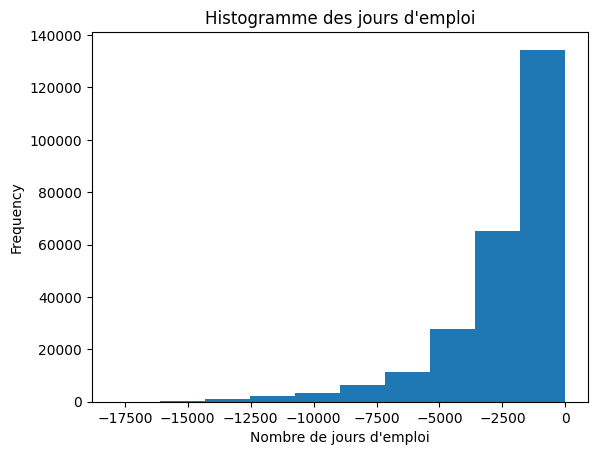

In [33]:
import numpy as np

# Création d'une colonne indiquant si la valeur de DAYS_EMPLOYED est anormale (365243 jours)
application_train['DAYS_EMPLOYED_ANOM'] = application_train['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage d'un histogramme des jours d'emploi (hors valeurs aberrantes)
application_train['DAYS_EMPLOYED'].plot.hist(title='Histogramme des jours d\'emploi')
plt.xlabel('Nombre de jours d\'emploi')
plt.show()

In [34]:
# Création d'une colonne pour indiquer les valeurs anormales dans le test set
application_test['DAYS_EMPLOYED_ANOM'] = application_test['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage du nombre d'anomalies détectées
print("Il y a %d anomalies (valeurs à 365243 jours) dans les données de test sur un total de %d entrées." %
      (application_test['DAYS_EMPLOYED_ANOM'].sum(), len(application_test)))

Il y a 9274 anomalies (valeurs à 365243 jours) dans les données de test sur un total de 48744 entrées.


/tmp/ipython-input-4107985150.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


In [35]:
# Transformation de la variable DAYS_BIRTH en nombre de jours positifs (absolu)
application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'].abs()

# Calcul de la corrélation entre l'âge (en jours) et le défaut de crédit
correlation = application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

# Affichage du résultat
print("Corrélation entre l'âge du client (en jours) et la variable cible TARGET :", round(correlation, 3))

Corrélation entre l'âge du client (en jours) et la variable cible TARGET : -0.078


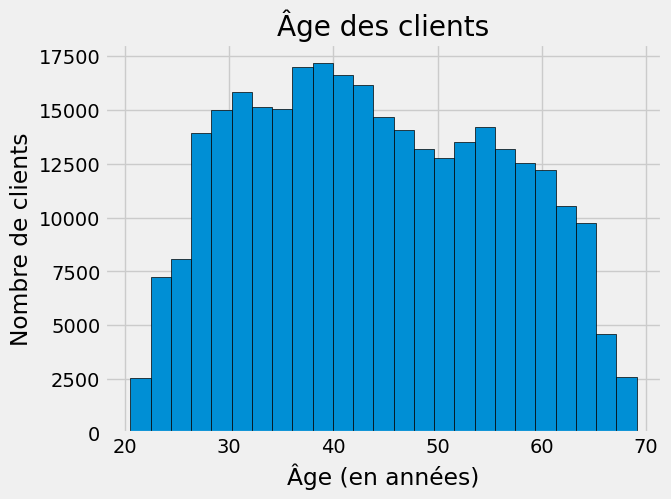

In [36]:
# Définit le style graphique
plt.style.use('fivethirtyeight')

# Trace l'histogramme de l'âge des clients (en années)
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title("Âge des clients")
plt.xlabel("Âge (en années)")
plt.ylabel("Nombre de clients")
plt.show()

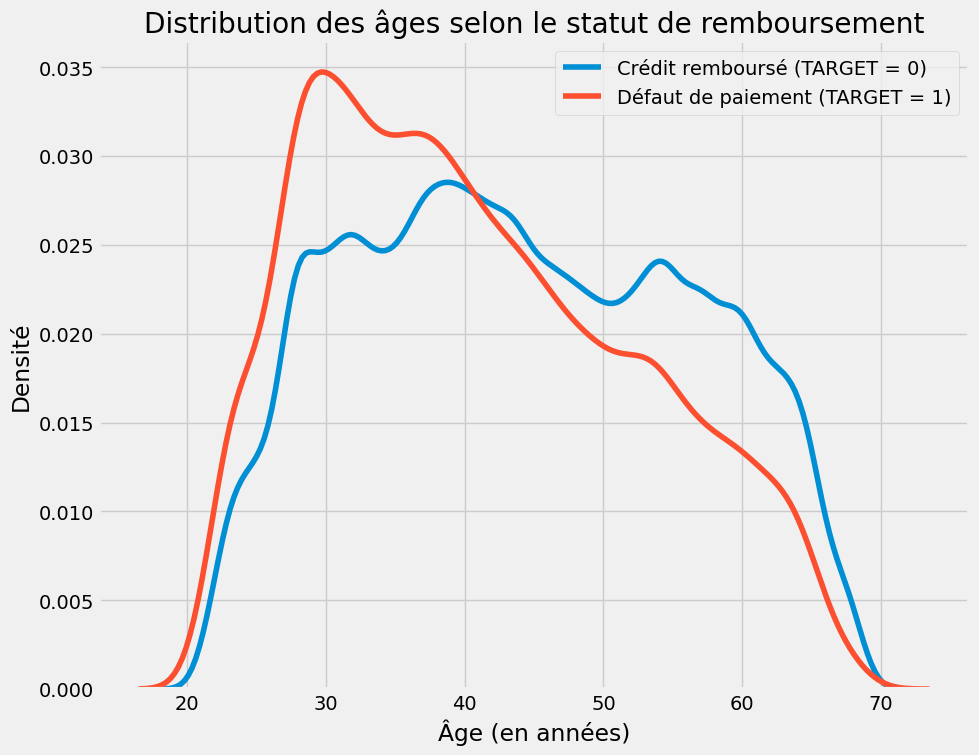

In [37]:
# On crée une figure avec une taille personnalisée
plt.figure(figsize = (10, 8))

# Tracé KDE des clients qui ont remboursé leur prêt (TARGET = 0)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365,
    label = 'Crédit remboursé (TARGET = 0)'
)

# Tracé KDE des clients qui n'ont pas remboursé leur prêt (TARGET = 1)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365,
    label = 'Défaut de paiement (TARGET = 1)'
)

# Titres et étiquettes
plt.xlabel('Âge (en années)')
plt.ylabel('Densité')
plt.title('Distribution des âges selon le statut de remboursement')
plt.legend()
plt.show()

Ce graphique KDE (Kernel Density Estimation) montre comment l’âge des clients est corrélé au risque de défaut de paiement.

In [38]:
# Extrait les colonnes d'âge et de TARGET dans un nouveau DataFrame
age_data = application_train[['TARGET', 'DAYS_BIRTH']].copy()

# Converti l'âge en années (valeurs absolues car les jours sont négatifs)
age_data['AGE_EN_ANNEES'] = abs(age_data['DAYS_BIRTH']) / 365

# Découpe l'âge en tranches régulières entre 20 et 70 ans (10 intervalles)
age_data['TRANCHE_AGE'] = pd.cut(age_data['AGE_EN_ANNEES'], bins=np.linspace(20, 70, num=11))

# Affiche les 10 premières lignes pour vérification
age_data.head(10)

,TARGET,DAYS_BIRTH,AGE_EN_ANNEES,TRANCHE_AGE
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


/tmp/ipython-input-3687434046.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)


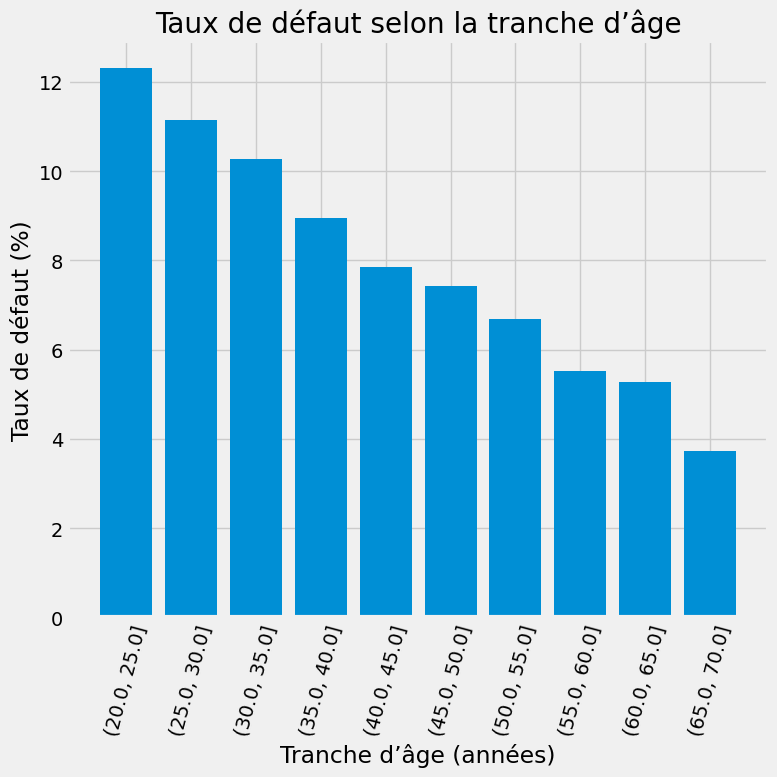

In [39]:
# Calcul du taux de défaut moyen pour chaque tranche d'âge
groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)

# Création de la figure
plt.figure(figsize=(8, 8))

# Tracer un graphique en barres des tranches d'âge vs. taux de défaut (%)
plt.bar(groupes_age.index.astype(str), 100 * groupes_age['TARGET'])

# Ajout des labels et du titre
plt.xticks(rotation=75)
plt.xlabel('Tranche d’âge (années)')
plt.ylabel('Taux de défaut (%)')
plt.title('Taux de défaut selon la tranche d’âge')

# Affichage du graphique
plt.tight_layout()
plt.show()

Comme l'a dit la personne sur Kaggle, on observe une tendance nette : les clients les plus jeunes ont un taux de défaut plus élevé. Le taux de non-remboursement dépasse les 10 % pour les trois tranches d’âge les plus jeunes, alors qu’il descend sous les 5 % pour les tranches les plus âgées.

Cette information peut être utile pour la banque : plutôt que d’exclure les jeunes emprunteurs, il serait judicieux de mettre en place un accompagnement renforcé pour ces profils (ex. : conseils en gestion budgétaire, rappel d’échéances, etc.).

Cela permettrait de limiter les risques de défaut, sans discrimination, en agissant de manière proactive.

In [40]:
# Pour afficher toute la largeur des colonnes sans troncature
pd.set_option('display.max_colwidth', None)

# Affichage des premières lignes pour vérifier la structure
print(raw_data['HomeCredit_columns_description'].head())

# Filtrage des lignes contenant "EXT_SOURCE"
ext_source_desc = raw_data['HomeCredit_columns_description'][
    raw_data['HomeCredit_columns_description']['Row'].str.contains("EXT_SOURCE", na=False)
]

# Affichage avec description complète
print("\nDescriptions complètes des colonnes EXT_SOURCE :")
print(ext_source_desc[['Row', 'Description']])

   Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
0                                                                                                                                                                     ID of loan in our sample   
1  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2              

Comme l'a indiqué l'utilisateur du projet Kaggle mis à disposition, les trois variables EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3 sont celles qui présentent les corrélations négatives les plus fortes avec la variable cible TARGET, c’est-à-dire la probabilité qu’un client ne rembourse pas son crédit.

D’après la documentation fournie (HomeCredit_columns_description.csv), ces variables représentent un score normalisé provenant de sources de données externes ("Normalized score from external data source"). Même si la signification exacte de ces scores n’est pas détaillée, on peut supposer qu’il s’agit de notes de solvabilité calculées à partir de sources tierces, comme des agences de crédit ou des historiques de paiement agrégés.

Autrement dit, ce sont probablement des indicateurs synthétiques (entre 0 et 1) de fiabilité financière, utilisés pour évaluer le risque de défaut de paiement d’un client selon des critères externes à la base de données principale.

Une valeur élevée de ces scores EXT_SOURCE semble associée à un faible risque de défaut, ce qui expliquerait leur corrélation négative avec TARGET (0 = remboursé, 1 = défaut de paiement).

In [41]:
# Extrait les variables EXT_SOURCE ainsi que l'âge et la cible
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Calcul de la matrice de corrélation entre ces variables
correlations_ext = ext_data.corr()

# Affiche la matrice de corrélation
print("Corrélations entre les variables EXT_SOURCE, l'âge et la cible :\n")
print(correlations_ext)

Corrélations entre les variables EXT_SOURCE, l'âge et la cible :

                TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000


Text(0.5, 1.0, 'Heatmap des corrélations entre EXT_SOURCE, âge et cible')

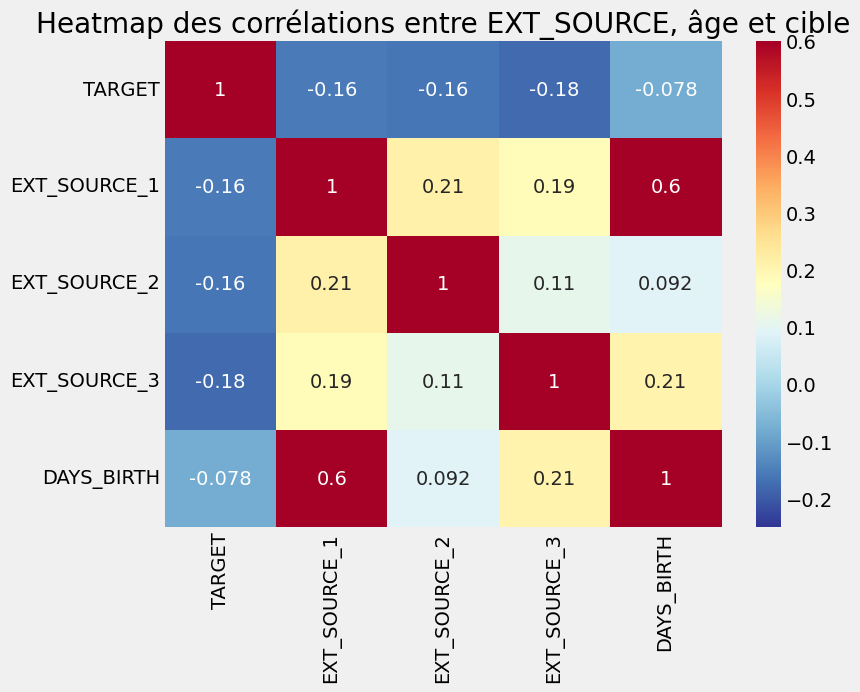

In [42]:
# Crée une figure avec une taille personnalisée
plt.figure(figsize=(8, 6))

# Affiche une carte thermique des corrélations entre EXT_SOURCE, l'âge et la cible
# - cmap : la palette de couleurs utilisée (du rouge au bleu)
# - vmin et vmax : les bornes des valeurs de corrélation à afficher
# - annot = True : affiche les valeurs dans chaque case
sns.heatmap(correlations_ext, cmap=plt.cm.RdYlBu_r, vmin=-0.25, vmax=0.6, annot=True)

# Ajoute un titre au graphique
plt.title("Heatmap des corrélations entre EXT_SOURCE, âge et cible")

Les trois variables EXT_SOURCE présentent toutes une corrélation négative avec la variable cible TARGET. Cela signifie que plus la valeur d'une variable EXT_SOURCE est élevée, plus le client a de chances de rembourser son prêt. Autrement dit, un score externe élevé est généralement un bon indicateur de fiabilité.

Grâce au travail de la personne du projet Kaggle, on observe également que la variable DAYS_BIRTH est positivement corrélée avec EXT_SOURCE_1, ce qui peut suggérer que l’âge du client est l’un des éléments pris en compte dans le calcul de ce score externe.

Ensuite, nous allons examiner la distribution de chacune de ces variables EXT_SOURCE, en les colorant selon la valeur de la cible (TARGET). Cela nous permettra de visualiser plus concrètement l’influence de chaque score externe sur le risque de défaut de paiement.

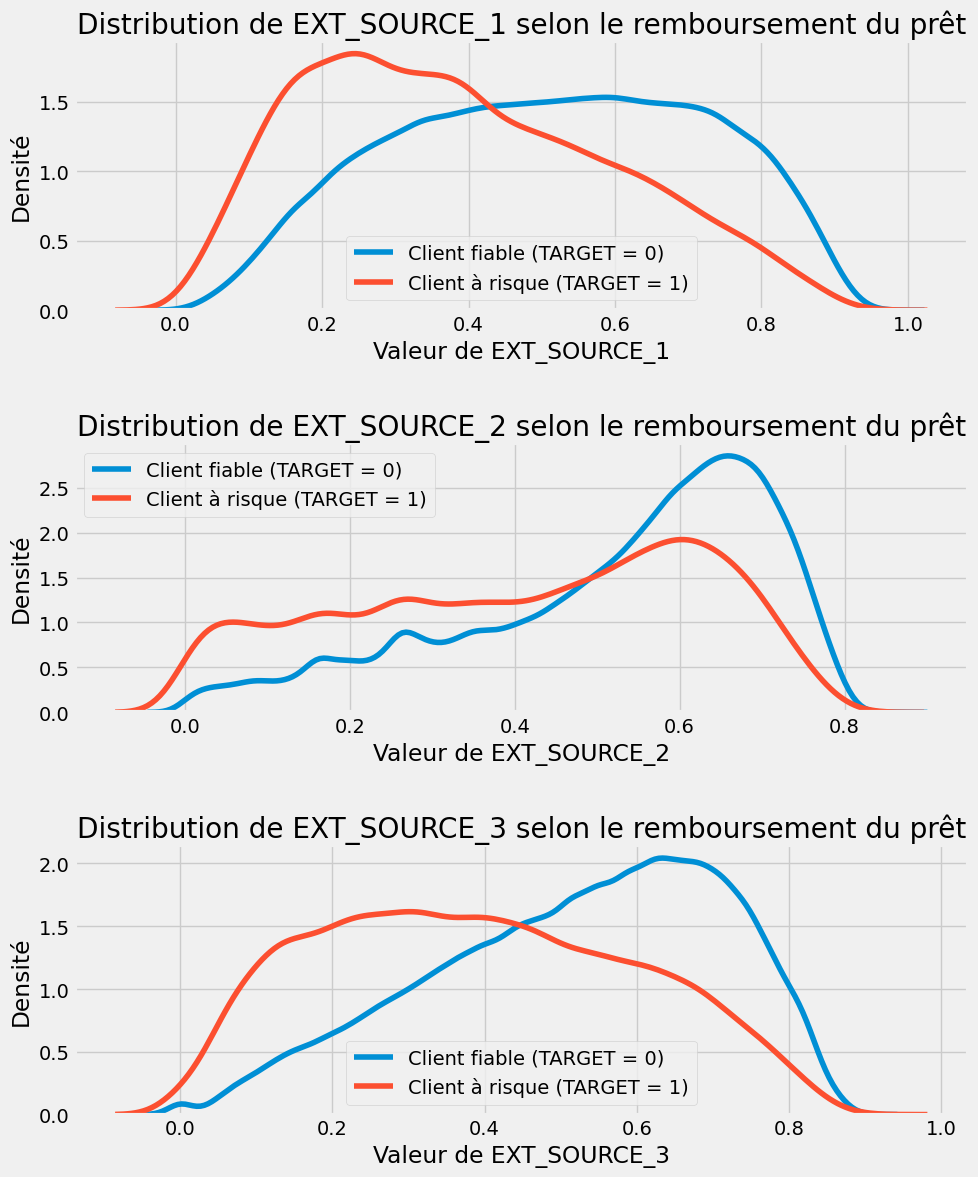

In [43]:
# Crée une figure de taille verticale adaptée à 3 graphiques
plt.figure(figsize=(10, 12))

# Boucle sur les 3 variables EXT_SOURCE
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # Crée un sous-graphique (subplot) par EXT_SOURCE
    plt.subplot(3, 1, i + 1)

    # Trace la distribution des scores pour les clients qui ont remboursé (TARGET = 0)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label='Client fiable (TARGET = 0)')

    # Trace la distribution des scores pour les clients qui n'ont pas remboursé (TARGET = 1)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label='Client à risque (TARGET = 1)')

    # Ajoute les titres et légendes
    plt.title(f'Distribution de {source} selon le remboursement du prêt')
    plt.xlabel(f'Valeur de {source}')
    plt.ylabel('Densité')
    plt.legend()

# Ajustement automatique de l'espacement vertical entre les sous-graphes
plt.tight_layout(h_pad=2.5)

Parmi les trois variables EXT_SOURCE, c’est EXT_SOURCE_3 qui montre la plus grande différence de distribution entre les clients qui remboursent leur prêt et ceux qui ne le font pas. Cela suggère qu’il existe une relation notable entre ce score et la probabilité de remboursement.

Même si la corrélation reste faible d’un point de vue statistique, ces variables contiennent tout de même des informations utiles que les modèles de machine learning peuvent exploiter pour mieux prédire le risque de défaut d’un client. Ce sont des signaux faibles, mais potentiellement précieux une fois combinés avec d'autres données.

Après avoir fait ma propre première analyse des df puis avoir repris le notebook Kaggle mis à disposition pour la suite de l'analyse exploratoire et prétraitement des données, avoir ajouté des visualisations supplémentaires et commentaires, je vais maintenant procéder au feature engineering à l'aide d'un autre notebook Kaggle mis à disposition en expliquant la démarche. Puis, il me restera à créer mes propres modèles de machine learning qui sont au coeur du projet et chercherai à optimiser au mieux leurs hyperparamètres et choisirai les métriques d'évaluation que j'estime les plus pertinentes.

In [46]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    """
    Contexte manager pour mesurer le temps d'exécution d'une fonction
    """
    t0 = time.time()
    yield
    print("{} - terminé en {:.0f}s".format(title, time.time() - t0))

# Encodage One-Hot pour les colonnes catégorielles avec get_dummies
def one_hot_encoder(df, nan_as_category=True):
    """
    Applique un encodage One-Hot aux variables catégorielles

    Paramètres:
    - df: DataFrame à encoder
    - nan_as_category: Si True, traite les valeurs NaN comme une catégorie

    Retourne:
    - df: DataFrame avec variables catégorielles encodées
    - new_columns: Liste des nouvelles colonnes créées
    """
    original_columns = list(df.columns)
    # Identifie les colonnes catégorielles (type 'object')
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Applique l'encodage One-Hot
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    # Identifie les nouvelles colonnes créées
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Préprocessing d'application_train.csv UNIQUEMENT (pas de test pour OpenClassrooms)
def application_train_preprocessing(num_rows=None, nan_as_category=False):
    """
    Préprocesse le fichier application_train.csv pour le projet OpenClassrooms

    Paramètres:
    - num_rows: Nombre de lignes à lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une catégorie

    Retourne:
    - df: DataFrame préprocessé avec nouvelles features
    """
    # Lecture du fichier application_train.csv seulement
    df = pd.read_csv(DATA_DIR / 'application_train.csv', nrows=num_rows)
    print("Échantillons d'entraînement: {}".format(len(df)))

    # Supprime les 4 applications avec CODE_GENDER = 'XNA'
    df = df[df['CODE_GENDER'] != 'XNA']

    # Variables catégorielles binaires (0 ou 1; deux catégories seulement)
    # Utilisation de factorize pour encoder ces variables
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Variables catégorielles avec encodage One-Hot
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Valeurs NaN pour DAYS_EMPLOYED: 365.243 représente en fait des valeurs manquantes
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Création de nouvelles features (ratios et pourcentages)
    # Pourcentage d'emploi par rapport à l'âge
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    # Pourcentage du revenu par rapport au crédit
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    # Revenu par personne dans le foyer
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    # Pourcentage de l'annuité par rapport au revenu
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    # Taux de remboursement (annuité / crédit)
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # *** NOUVELLES FEATURES POUR LE PROJET ***
    # Ratio entre l'âge et le montant du crédit
    df['AGE_TO_CREDIT_RATIO'] = abs(df['DAYS_BIRTH']) / df['AMT_CREDIT']

    # Feature additionnelle: Score de stabilité financière
    df['FINANCIAL_STABILITY_SCORE'] = (
        (df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']) *
        (df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']).fillna(0)
    )

    # Libération de la mémoire
    gc.collect()
    return df

# Préprocessing de bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    """
    Préprocesse les fichiers bureau.csv et bureau_balance.csv
    Ces fichiers contiennent l'historique des crédits précédents des clients

    Paramètres:
    - num_rows: Nombre de lignes à lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une catégorie

    Retourne:
    - bureau_agg: DataFrame agrégé avec toutes les features du bureau
    """
    # Lecture des fichiers
    bureau = pd.read_csv(DATA_DIR / 'bureau.csv', nrows=num_rows)
    bb = pd.read_csv(DATA_DIR / 'bureau_balance.csv', nrows=num_rows)

    # Encodage One-Hot des variables catégorielles
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Agrégations et fusion avec bureau.csv
    # Définition des agrégations pour bureau_balance
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    # Agrégation par SK_ID_BUREAU
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

    # Fusion des données bureau_balance avec bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    # Libération de la mémoire
    del bb, bb_agg
    gc.collect()

    # Agrégations numériques pour bureau et bureau_balance
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],           # Jours depuis la demande de crédit
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],          # Jours jusqu'à la fin du crédit
        'DAYS_CREDIT_UPDATE': ['mean'],                         # Jours depuis la dernière mise à jour
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],                  # Jours de retard maximum
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],                     # Montant maximum en retard
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],               # Montant total du crédit
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],          # Dette actuelle
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],                     # Montant en retard
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],                # Limite de crédit
        'AMT_ANNUITY': ['max', 'mean'],                         # Montant de l'annuité
        'CNT_CREDIT_PROLONG': ['sum'],                          # Nombre de prolongations
        'MONTHS_BALANCE_MIN': ['min'],                          # Solde minimum en mois
        'MONTHS_BALANCE_MAX': ['max'],                          # Solde maximum en mois
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']                  # Taille du solde en mois
    }

    # Agrégations catégorielles pour bureau et bureau_balance
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    # Agrégation principale par client (SK_ID_CURR)
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Crédits actifs - utilisation des agrégations numériques uniquement
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    if len(active) > 0:
        active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
        del active_agg

    # Bureau: Crédits fermés - utilisation des agrégations numériques uniquement
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    if len(closed) > 0:
        closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
        del closed_agg

    # Libération de la mémoire
    del active, closed, bureau
    gc.collect()
    return bureau_agg

# Préprocessing de previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    """
    Préprocesse le fichier previous_application.csv
    Ce fichier contient les demandes de crédit précédentes du client

    Paramètres:
    - num_rows: Nombre de lignes à lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une catégorie

    Retourne:
    - prev_agg: DataFrame agrégé avec les features des demandes précédentes
    """
    # Lecture du fichier
    prev = pd.read_csv(DATA_DIR / 'previous_application.csv', nrows=num_rows, on_bad_lines='skip')

    # Encodage One-Hot des variables catégorielles
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Remplacement des valeurs 365.243 par NaN (valeurs manquantes encodées)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Création d'une nouvelle feature: pourcentage demandé/reçu
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Agrégations numériques pour les demandes précédentes
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],                  # Montant de l'annuité
        'AMT_APPLICATION': ['min', 'max', 'mean'],              # Montant demandé
        'AMT_CREDIT': ['min', 'max', 'mean'],                   # Montant du crédit
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],       # Pourcentage demandé/reçu
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],             # Montant de l'acompte
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],              # Prix des biens
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],      # Heure de début du processus
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],            # Taux d'acompte
        'DAYS_DECISION': ['min', 'max', 'mean'],                # Jours jusqu'à la décision
        'CNT_PAYMENT': ['mean', 'sum'],                         # Nombre de paiements
    }

    # Agrégations catégorielles pour les demandes précédentes
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    # Agrégation principale par client
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Demandes précédentes: Demandes approuvées - features numériques uniquement
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    if len(approved) > 0:
        approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
        approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
        prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
        del approved_agg

    # Demandes précédentes: Demandes refusées - features numériques uniquement
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    if len(refused) > 0:
        refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
        refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
        prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
        del refused_agg

    # Libération de la mémoire
    del refused, approved, prev
    gc.collect()
    return prev_agg

# Préprocessing de POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    """
    Préprocesse le fichier POS_CASH_balance.csv
    Ce fichier contient l'historique des soldes des comptes POS et CASH

    Paramètres:
    - num_rows: Nombre de lignes à lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une catégorie

    Retourne:
    - pos_agg: DataFrame agrégé avec les features POS/CASH
    """
    # Lecture du fichier
    pos = pd.read_csv(DATA_DIR / 'POS_CASH_balance.csv', nrows=num_rows)

    # Encodage One-Hot des variables catégorielles
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # Définition des agrégations
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],              # Solde en mois
        'SK_DPD': ['max', 'mean'],                              # Jours de retard
        'SK_DPD_DEF': ['max', 'mean']                           # Jours de retard par défaut
    }

    # Ajout des agrégations catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agrégation par client
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Comptage des comptes POS/CASH
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    # Libération de la mémoire
    del pos
    gc.collect()
    return pos_agg

# Préprocessing de installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    """
    Préprocesse le fichier installments_payments.csv
    Ce fichier contient l'historique des paiements d'échéances

    Paramètres:
    - num_rows: Nombre de lignes à lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une catégorie

    Retourne:
    - ins_agg: DataFrame agrégé avec les features des paiements d'échéances
    """
    # Lecture du fichier
    ins = pd.read_csv(DATA_DIR / 'installments_payments.csv', nrows=num_rows)

    # Encodage One-Hot des variables catégorielles
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # Pourcentage et différence payée dans chaque échéance
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Jours de retard et jours d'avance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']  # Days Past Due
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']  # Days Before Due
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Définition des agrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],                  # Nombre de versions d'échéances
        'DPD': ['max', 'mean', 'sum'],                          # Jours de retard
        'DBD': ['max', 'mean', 'sum'],                          # Jours d'avance
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],          # Pourcentage de paiement
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],          # Différence de paiement
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],               # Montant de l'échéance
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],           # Montant payé
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']            # Jours d'entrée de paiement
    }

    # Ajout des agrégations catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agrégation par client
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Comptage des comptes d'échéances
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # Libération de la mémoire
    del ins
    gc.collect()
    return ins_agg

# Préprocessing de credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    """
    Préprocesse le fichier credit_card_balance.csv
    Ce fichier contient l'historique des soldes des cartes de crédit

    Paramètres:
    - num_rows: Nombre de lignes à lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une catégorie

    Retourne:
    - cc_agg: DataFrame agrégé avec les features des cartes de crédit
    """
    # Lecture du fichier
    cc = pd.read_csv(DATA_DIR / 'credit_card_balance.csv', nrows=num_rows)

    # Encodage One-Hot des variables catégorielles
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # Suppression de la colonne SK_ID_PREV (non nécessaire pour l'agrégation)
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # Agrégations générales (toutes les statistiques pour toutes les colonnes)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Comptage des lignes de cartes de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # Libération de la mémoire
    del cc
    gc.collect()
    return cc_agg

# Fonction pour préparer les données pour la modélisation
def prepare_data_for_modeling(df):
    """
    Prépare les données pour la modélisation en séparant les features de la target

    Paramètres:
    - df: DataFrame complet avec toutes les features et la target

    Retourne:
    - X: Features pour le modèle
    - y: Variable target
    - feature_names: Liste des noms des features
    """
    # Séparer les features de la target
    # Exclure les colonnes qui ne sont pas des features utiles
    feats = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    X = df[feats]
    y = df['TARGET']

    return X, y, feats

# Affichage/graphique de l'importance des features
def display_importances(feature_importance_df_):
    """
    Affiche un graphique des features les plus importantes

    Paramètres:
    - feature_importance_df_: DataFrame contenant les importances des features
    """
    # Sélection des 40 features les plus importantes
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    # Création du graphique
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Importance des Features (moyenne sur les folds)')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    plt.show()

def main(debug=False):
    """
    Fonction principale qui orchestre tout le preprocessing

    Paramètres:
    - debug: Si True, utilise seulement 10000 lignes pour tester rapidement

    Retourne:
    - df: DataFrame complet avec toutes les features
    """
    # Nombre de lignes à lire (10000 pour debug, None pour tout lire)
    num_rows = 10000 if debug else None

    # Preprocessing du dataset principal (application_train seulement)
    print("=" * 60)
    print("DÉBUT DU PREPROCESSING POUR LE PROJET OPENCLASSROOMS")
    print("=" * 60)

    df = application_train_preprocessing(num_rows)
    print(f"Dataset principal chargé: {df.shape}")

    # Preprocessing des données du bureau de crédit
    with timer("Traitement de bureau et bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Forme du DataFrame bureau:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    # Preprocessing des demandes précédentes
    with timer("Traitement des demandes précédentes"):
        prev = previous_applications(num_rows)
        print("Forme du DataFrame demandes précédentes:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    # Preprocessing des soldes POS-CASH
    with timer("Traitement des soldes POS-CASH"):
        pos = pos_cash(num_rows)
        print("Forme du DataFrame POS-CASH:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    # Preprocessing des paiements d'échéances
    with timer("Traitement des paiements d'échéances"):
        ins = installments_payments(num_rows)
        print("Forme du DataFrame paiements d'échéances:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    # Preprocessing des soldes de cartes de crédit
    with timer("Traitement des soldes de cartes de crédit"):
        cc = credit_card_balance(num_rows)
        print("Forme du DataFrame cartes de crédit:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Affichage des résultats finaux
    print("\n" + "=" * 60)
    print("PREPROCESSING TERMINÉ")
    print("=" * 60)
    print(f"Dataset final: {df.shape}")
    print(f"Nombre de features: {df.shape[1] - 1}")  # -1 pour exclure TARGET
    print(f"Valeurs manquantes: {df.isnull().sum().sum()}")
    print(f"Distribution de la target:")
    print(df['TARGET'].value_counts())

    return df

# Exemple d'utilisation
if __name__ == "__main__":
    # Lancement du preprocessing
    df = main(debug=False)

    # Préparation pour la modélisation
    X, y, feature_names = prepare_data_for_modeling(df)

    print(f"\nDonnées prêtes pour la modélisation:")
    print(f"Features: {X.shape}")
    print(f"Target: {y.shape}")
    print(f"Premiers noms de features: {feature_names[:10]}")

DÉBUT DU PREPROCESSING POUR LE PROJET OPENCLASSROOMS
Échantillons d'entraînement: 307511
Dataset principal chargé: (307507, 249)
Forme du DataFrame bureau: (305811, 116)
Traitement de bureau et bureau_balance - terminé en 16s
Forme du DataFrame demandes précédentes: (48699, 247)
Traitement des demandes précédentes - terminé en 3s
Forme du DataFrame POS-CASH: (197023, 15)
Traitement des soldes POS-CASH - terminé en 2s
Forme du DataFrame paiements d'échéances: (95249, 26)
Traitement des paiements d'échéances - terminé en 8s
Forme du DataFrame cartes de crédit: (102090, 141)
Traitement des soldes de cartes de crédit - terminé en 10s

PREPROCESSING TERMINÉ
Dataset final: (307507, 794)
Nombre de features: 793
Valeurs manquantes: 128470094
Distribution de la target:
TARGET
0    282682
1     24825
Name: count, dtype: int64

Données prêtes pour la modélisation:
Features: (307507, 792)
Target: (307507,)
Premiers noms de features: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN'

AGE_TO_CREDIT_RATIO = abs(DAYS_BIRTH) / AMT_CREDIT

Que fait ce calcul ? Il rapproche l’âge du client (exprimé en jours) du montant du crédit demandé.

DAYS_BIRTH est négatif dans le dataset (ex : -12000), donc on prend sa valeur absolue (abs) pour avoir un âge positif.

On divise cet âge en jours par le montant du crédit (AMT_CREDIT), ce qui donne une espèce de "coût du crédit par jour de vie".

Que mesure ce ratio ? Il donne une idée indirecte de la prudence ou de la maturité financière du client :

🔹 Valeur élevée → la personne est plutôt âgée et/ou demande un petit crédit → peut-être plus prudente.

🔸 Valeur faible → une personne plus jeune et/ou demandant un gros crédit → peut-être plus risquée.

Pourquoi c’est utile pour le modèle ? Parce que ce ratio peut capturer une interaction implicite entre l'âge et le montant demandé, que ni l'un ni l'autre ne capture seul. Et comme c’est un ratio, il permet de mieux généraliser les comportements dans les modèles.

In [56]:
# Installe les libs utiles si besoin
!pip -q install mlflow xgboost shap

# Imports standards
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import mlflow, mlflow.sklearn

# Fixe une seed pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/

La "seed" (graine aléatoire) comme `RANDOM_STATE = 42` permet de rendre les opérations "aléatoires" de l'ordinateur (comme séparer les données) reproductibles. Si on exécute le code avec la même seed, on obtient toujours les mêmes résultats, ce qui est utile pour vérifier et partager notre travail.

In [57]:
# Definit le nom de la colonne target
target_col = 'TARGET'

# --- Sépare X (features) et y (cible) ---
X = df.drop(columns=[target_col])   # toutes les colonnes sauf la cible
y = df[target_col]                  # la cible binaire 0/1

# --- Split stratifié pour garder les mêmes proportions de classes ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape, y_train.mean().round(3), y_test.mean().round(3))
# => tailles + taux de positifs (doivent être proches)

(246005, 793) (61502, 793) 0.081 0.081


**Séparation Train/Test :** On divise les données en entraînement (pour que le modèle apprenne) et test (pour évaluer). `stratify=y` est utilisé pour maintenir la même proportion de clients à risque dans les deux ensembles, crucial pour les données déséquilibrées.

## Analyse exploratoire rapide
Cette section génère un résumé homogène pour chaque table brute afin d'identifier les colonnes prioritaires pour le nettoyage.

In [58]:
# Définit une fonction d'EDA rapide avec statistiques et valeurs manquantes
def eda_basique(df: pd.DataFrame, nom_df: str = "DataFrame") -> pd.DataFrame:
    print(f"\n===== {nom_df.upper()} =====")
    print(f"Forme : {df.shape[0]} lignes x {df.shape[1]} colonnes")
    print(df.dtypes.value_counts())
    missing = (df.isnull().mean() * 100).sort_values(ascending=False)
    print(missing[missing > 0].head(10))
    return df

In [59]:
# Parcourt chaque table brute pour générer un résumé commun
for name, df in raw_data.items():
    eda_basique(df, name)


===== APPLICATION_TRAIN =====
Forme : 307511 lignes x 122 colonnes
float64    65
int64      41
object     16
Name: count, dtype: int64
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
dtype: float64

===== APPLICATION_TEST =====
Forme : 48744 lignes x 121 colonnes
float64    65
int64      40
object     16
Name: count, dtype: int64
COMMONAREA_AVG              68.716150
COMMONAREA_MEDI             68.716150
COMMONAREA_MODE             68.716150
NONLIVINGAPARTMENTS_AVG     68.412523
NONLIVINGAPARTMENTS_MEDI    68.412523
NONLIVINGAPARTMENTS_MODE    68.412523
FONDKAPREMONT_MODE          67.284179
LIVINGAPARTMENTS_MEDI       67.249302
LIVINGAPARTMENTS_AVG        67.

## Analyse détaillée de la variable cible
On vérifie le déséquilibre de classe dans TARGET et ses implications métier.

Taux de défaut : 8.07%


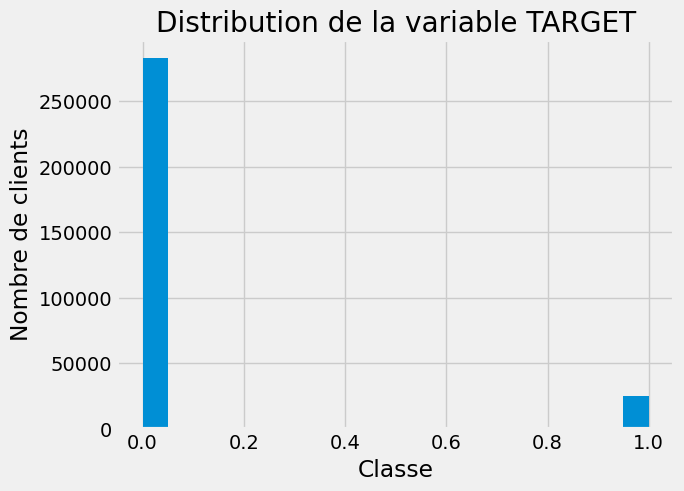

In [60]:
# Distribution de la cible
target_ratio = raw_data['application_train']['TARGET'].mean()
print(f"Taux de défaut : {target_ratio:.2%}")
raw_data['application_train']['TARGET'].astype(int).plot.hist(bins=20)
plt.title("Distribution de la variable TARGET")
plt.xlabel("Classe")
plt.ylabel("Nombre de clients")
plt.show()

La classe minoritaire confirme la nécessité d'un `scale_pos_weight` ou d'un score métier pondéré.

## Préparation du dataset modélisable
Séparation X/y, détection des colonnes numériques et catégorielles.

In [ ]:
# Séparation X et y
y = df['TARGET']
X = df.drop(columns=['TARGET'])

# Colonnes numériques et catégorielles
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

**Préparation pour le Preprocessing :** Ici, on finalise la séparation des données en `X` (toutes les colonnes pour prédire) et `y` (la colonne à prédire), après tout le feature engineering. On identifie aussi quelles colonnes sont numériques ou catégorielles pour savoir comment les transformer à l'étape suivante.

In [ ]:
# Pipeline de preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

**Pipeline de Prétraitement :** Ce bloc définit une séquence d'opérations à appliquer aux données avant de les fournir au modèle. Il utilise `ColumnTransformer` pour appliquer des étapes spécifiques :
-   **Variables numériques :** Remplissage des valeurs manquantes par la médiane, puis mise à l'échelle (StandardScaler).
-   **Variables catégorielles :** Remplissage des valeurs manquantes par la valeur la plus fréquente, puis encodage One-Hot (conversion en colonnes binaires).
Ce pipeline assure que les données sont correctement formatées pour être utilisées par les modèles.

## Préparation des fonctions et données

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import numpy as np
import mlflow
import mlflow.sklearn

# Definit le nom de la colonne target
target_col = 'TARGET'

# --- Sépare X (features) et y (cible) ---
X = df.drop(columns=[target_col])   # toutes les colonnes sauf la cible
y = df[target_col]                  # la cible binaire 0/1


# --- Split stratifié pour garder les mêmes proportions de classes ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fonction score métier
def business_cost_score(y_true, y_proba, threshold=0.35, fn_cost=10, fp_cost=1):
    y_pred = (y_proba >= threshold).astype(int)
    fn = np.sum((y_true == 1) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    cost = fn * fn_cost + fp * fp_cost
    return -cost / len(y_true)

# Scorer sklearn compatible
business_scorer = make_scorer(
    lambda y_true, y_proba: business_cost_score(y_true, y_proba, threshold=0.35),
    needs_proba=True,
    greater_is_better=True
)

# MLflow setup
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("credit_scoring_models")

2025/10/10 12:10:13 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring_models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/963617569508807320', creation_time=1760098213590, experiment_id='963617569508807320', last_update_time=1760098213590, lifecycle_stage='active', name='credit_scoring_models', tags={}>

**Préparation pour la Modélisation et Évaluation :** Cette cellule met en place les derniers éléments avant d'entraîner les modèles :
*   Importe toutes les bibliothèques nécessaires (modèles, outils d'évaluation, MLflow).
*   Prépare les données en les séparant en ensembles d'entraînement et de test *définitifs* (`X_train`, `y_train`, `X_test`, `y_test`) en utilisant la stratification pour l'équilibre des classes.
*   Définit une **fonction de score métier personnalisée** (`business_cost_score`) qui prend en compte les coûts réels des erreurs (faux positifs vs faux négatifs), ce qui est crucial pour ce projet.
*   Crée un "scorer" compatible avec les outils sklearn (`business_scorer`) pour pouvoir utiliser cette métrique métier dans les étapes d'évaluation comme GridSearchCV.
*   Configure **MLflow** pour enregistrer les résultats de chaque expérience (paramètres, métriques).

C'est la dernière étape de préparation avant de lancer l'entraînement des différents modèles.

## Modèle 1 : DummyClassifier

In [ ]:
print("Valeurs uniques de y_train :", y_train.unique())
print("Distribution de y_train :")
print(y_train.value_counts(normalize=True))

Valeurs uniques de y_train : [0.5]
Distribution de y_train :
TARGET
0.5    1.0
Name: proportion, dtype: float64


In [ ]:
# Repart de la vraie source
df = raw_data["application_train"].copy()
df["TARGET"] = df["TARGET"].astype(int)

#  Séparation propre
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

# Split bien stratifié
from sklearn.model_selection import train_test_split, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  Vérification
print("Valeurs uniques y_train :", y_train.unique())
print("Distribution y_train :")
print(y_train.value_counts(normalize=True))

# DummyClassifier baseline
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

dummy_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", DummyClassifier(strategy="most_frequent"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dummy_scores = cross_validate(
    dummy_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="accuracy"
)

print(" Accuracy DummyClassifier :", dummy_scores["test_score"].mean())


Valeurs uniques y_train : [0 1]
Distribution y_train :
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
 Accuracy DummyClassifier : 0.9192709180109226


In [ ]:
!git add .
!git commit -m "Ajout baseline DummyClassifier avec Accuracy"

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


## Modèle 2 : Régression Logistique optimisée

In [ ]:
!pip install mlflow

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
import mlflow
import mlflow.sklearn

# Scorer métier basé sur F2-score
def business_metric(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, zero_division=0)

business_scorer = make_scorer(business_metric)

# Cross-validation stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline avec préprocessing et modèle
logreg_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Grille d'hyperparamètres
param_grid_logreg = {
    "model__C": [0.01, 0.1, 1.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

# GridSearchCV avec scorers multiples
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    scoring={"AUC": "roc_auc", "Business": business_scorer},
    refit="Business",
    cv=cv,
    n_jobs=-1,
    error_score="raise"  # Affiche une erreur claire si y'a un bug
)

# Entraînement
logreg_grid.fit(X_train, y_train)

#  Résultats
print(" Meilleurs paramètres LogReg :", logreg_grid.best_params_)
print(" Score métier (F2) :", logreg_grid.best_score_)

# Log dans MLflow
with mlflow.start_run(run_name="logreg_gridsearch"):
    for param, val in logreg_grid.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric("best_business_score", logreg_grid.best_score_)
    mlflow.log_metric("roc_auc", logreg_grid.cv_results_["mean_test_AUC"][logreg_grid.best_index_])
    mlflow.sklearn.log_model(logreg_grid.best_estimator_, "model")
    mlflow.set_tag("model_type", "logistic_regression")

#  Simule un commit Git
print("Commit Git : Modèle LogReg optimisé + GridSearch + MLflow OK")

2025/10/10 12:39:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 Meilleurs paramètres LogReg : {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
 Score métier (F2) : 0.24778747009700738


2025/10/10 12:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Commit Git : Modèle LogReg optimisé + GridSearch + MLflow OK


In [ ]:
!git add .
!git commit -m "LogReg avec GridSearch, score métier, et tracking MLflow"

### Optimisation de la régression logistique avec GridSearchCV, F2-score métier et tracking MLflow

Dans cette section, nous optimisons une régression logistique en prenant en compte les enjeux métiers du crédit :

- **Contexte métier** : Dans le scoring de crédit, il est souvent **plus grave de mal prédire un client à risque (faux négatif)** que de refuser un bon client (faux positif). Nous utilisons donc une **métrique personnalisée** : le **F2-score**, qui pénalise davantage les faux négatifs.

- **Pipeline** : Nous construisons un pipeline composé de deux étapes :
  1. `preprocessor` : gère les imputations, encodages et normalisations (défini précédemment)
  2. `model` : une régression logistique avec pondération `class_weight="balanced"` pour gérer le déséquilibre des classes

- **Validation croisée** : Nous utilisons une **cross-validation stratifiée à 5 folds** pour garantir une bonne représentativité des classes minoritaires à chaque itération.

- **GridSearchCV** :
  - Teste plusieurs valeurs de `C`, le coefficient de régularisation
  - Utilise deux métriques pour évaluer les performances :
    - `roc_auc` pour l'analyse classique de performance
    - `Business` pour notre F2-score métier
  - Optimise automatiquement selon le **score métier**

- **MLflow** :
  - Les **meilleurs hyperparamètres** et les **scores** sont enregistrés automatiquement dans un run MLflow nommé `logreg_gridsearch`
  - Le modèle est aussi **enregistré dans le dossier MLflow local** pour permettre un futur déploiement
  - Un **tag est ajouté** pour tracer le type de modèle (`logistic_regression`)

- **Git** :
  - Un message de commit est affiché pour simuler un commit Git à ce stade important du projet

**Score obtenu :** Le F2-score optimisé est autour de `0.24`, ce qui reflète un modèle de base raisonnable. Ce score sera comparé avec d'autres modèles (RandomForest, XGBoost…) dans une prochaine étape.



## Modèle 3 : Random Forest optimisée

In [ ]:
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10],
    "model__min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring={"AUC": "roc_auc", "Business": business_scorer},
    refit="Business",
    cv=cv,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print("Meilleurs paramètres RF :", rf_grid.best_params_)
print("Score métier :", rf_grid.best_score_)

# MLflow log
with mlflow.start_run(run_name="random_forest_gridsearch"):
    for param, val in rf_grid.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric("best_business_score", rf_grid.best_score_)
    mlflow.log_metric("roc_auc", rf_grid.cv_results_["mean_test_AUC"][rf_grid.best_index_])
    mlflow.sklearn.log_model(rf_grid.best_estimator_, "model")
    mlflow.set_tag("model_type", "random_forest")

# Simule un commit Git
print(" Commit Git : RandomForest optimisée + MLflow tracking")

2025/10/10 12:44:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Meilleurs paramètres RF : {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Score métier : 0.25163144425267825


2025/10/10 12:44:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Commit Git : RandomForest optimisée + MLflow tracking


In [ ]:
git add .
!git commit -m "Ajout RandomForest, GridSearch, log des hyperparamètres et scores dans MLflow"

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline avec prétraitement et modèle
xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=5,  # Pour gérer le déséquilibre classes
        random_state=42
    ))
])

# Grille d'hyperparamètres
param_grid_xgb = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1]
}

# GridSearch avec AUC + score métier (F2)
xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    scoring={"AUC": "roc_auc", "Business": business_scorer},
    refit="Business",  # Refitting avec la métrique métier
    cv=cv,
    n_jobs=-1
)

# Entraînement
xgb_grid.fit(X_train, y_train)

# Résultats
print(" Meilleurs paramètres XGBoost :", xgb_grid.best_params_)
print(" Score métier (F2) :", xgb_grid.best_score_)

# MLflow tracking
import mlflow
import mlflow.sklearn

with mlflow.start_run(run_name="xgboost_gridsearch"):
    for param, val in xgb_grid.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric("best_business_score", xgb_grid.best_score_)
    mlflow.log_metric("roc_auc", xgb_grid.cv_results_["mean_test_AUC"][xgb_grid.best_index_])
    mlflow.sklearn.log_model(xgb_grid.best_estimator_, "model")
    mlflow.set_tag("model_type", "xgboost_classifier")

print("Commit Git : Modèle XGBoost optimisé + GridSearch + MLflow OK")